In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.linear_model import LinearRegression

In [93]:
X = pd.read_excel("cassav.xlsx", "X")
y = pd.read_excel("cassav.xlsx", "Y")["tbc"]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

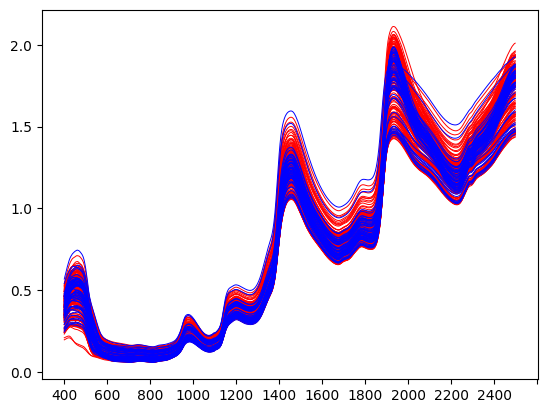

In [95]:
import matplotlib.ticker as ticker 
fig, ax = plt.subplots(1, 1) 
ax.xaxis.set_major_locator(ticker.MultipleLocator(100)) 
ax.plot(X_train.T, c='r', linewidth=0.7)
ax.plot(X_test.T, c='b', linewidth=0.7)
plt.show()

In [96]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

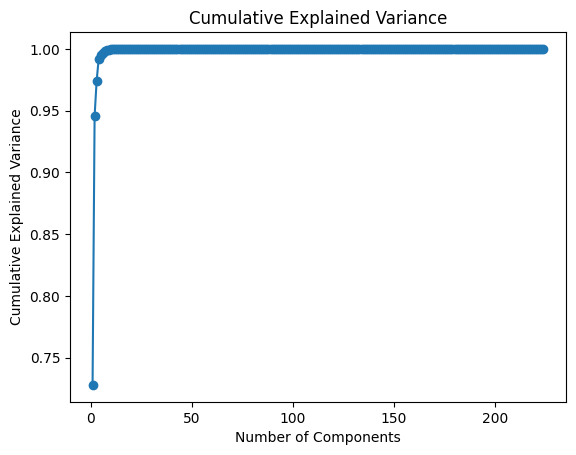

In [97]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

In [98]:
r2_df = []
for i in range (1, 200):
    pca = PCA(i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_pca, y_train)
    y_pred = lr.predict(X_test_pca)
    r2_df.append([i, r2_score(y_test, y_pred)])
r2_df = pd.DataFrame(r2_df, columns=["PCs", "r2_score"])
print(r2_df.sort_values(by=['r2_score'], ascending=False).head(10))

    PCs  r2_score
85   86  0.926165
82   83  0.925013
83   84  0.924754
80   81  0.924744
84   85  0.924104
98   99  0.923893
87   88  0.923777
81   82  0.923673
88   89  0.923516
86   87  0.923425


In [105]:
n_components = 86
pca = PCA(n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [106]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_pca.shape[1],)))
    for i in range (0, hp.Int('layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('unit_' + str(i + 1), min_value=2, max_value=60, step=2)
                               , activation=hp.Choice('act_'+str(i + 1), ['relu', 'tanh'])))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam',
                    loss = 'mse', metrics = ['mae'])
    return model
tuner = RandomSearch(
    build_model,
    objective = 'val_mae',
    max_trials = 10,
    executions_per_trial = 3,
)
tuner.search(X_train_pca, y_train, epochs=220, validation_split=0.1, batch_size=12)

Trial 10 Complete [00h 00m 58s]
val_mae: 0.8026662667592367

Best val_mae So Far: 0.61341792345047
Total elapsed time: 00h 10m 38s


In [125]:
print(tuner.results_summary())

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 06 summary
Hyperparameters:
layers: 2
unit_1: 58
act_1: tanh
unit_2: 12
act_2: relu
unit_3: 36
act_3: relu
Score: 0.61341792345047

Trial 04 summary
Hyperparameters:
layers: 3
unit_1: 14
act_1: relu
unit_2: 38
act_2: relu
unit_3: 22
act_3: relu
Score: 0.6523094971974691

Trial 01 summary
Hyperparameters:
layers: 3
unit_1: 42
act_1: tanh
unit_2: 8
act_2: relu
unit_3: 18
act_3: tanh
Score: 0.6705125371615092

Trial 08 summary
Hyperparameters:
layers: 2
unit_1: 28
act_1: tanh
unit_2: 56
act_2: tanh
unit_3: 14
act_3: tanh
Score: 0.6952051719029745

Trial 05 summary
Hyperparameters:
layers: 1
unit_1: 44
act_1: relu
unit_2: 42
act_2: tanh
unit_3: 46
act_3: relu
Score: 0.7086853981018066

Trial 02 summary
Hyperparameters:
layers: 1
unit_1: 60
act_1: relu
unit_2: 46
act_2: tanh
unit_3: 16
act_3: relu
Score: 0.7166608174641927

Trial 03 summary
Hyperparameters:
layers: 1
unit_1

In [118]:
# Tạo mô hình
model = keras.Sequential([
    layers.Input(shape=(X_train_pca.shape[1])),
    layers.Dense(58, activation='tanh'),
    layers.Dense(12, activation='relu'),
    layers.Dense(36, activation='relu'),
    layers.Dense(1, activation='linear')
])
# Đóng gói mô hình
model.compile(optimizer='adam',
              loss='mse',  
              metrics=['mae'])
# Huấn luyện mô hình
history = model.fit(X_train_pca, y_train, epochs=220, batch_size=12, validation_split=0.1)

Epoch 1/220
17/17 [==============================] - 1s 17ms/step - loss: 51.7863 - mae: 6.2000 - val_loss: 50.5435 - val_mae: 6.4915
Epoch 2/220
17/17 [==============================] - 0s 5ms/step - loss: 44.6450 - mae: 5.6509 - val_loss: 39.5791 - val_mae: 5.6280
Epoch 3/220
17/17 [==============================] - 0s 5ms/step - loss: 35.3515 - mae: 4.9723 - val_loss: 26.3095 - val_mae: 4.4543
Epoch 4/220
17/17 [==============================] - 0s 4ms/step - loss: 24.9813 - mae: 4.1138 - val_loss: 15.5013 - val_mae: 3.2090
Epoch 5/220
17/17 [==============================] - 0s 3ms/step - loss: 18.7328 - mae: 3.5277 - val_loss: 9.6885 - val_mae: 2.3969
Epoch 6/220
17/17 [==============================] - 0s 4ms/step - loss: 13.8215 - mae: 3.0616 - val_loss: 8.0379 - val_mae: 2.2961
Epoch 7/220
17/17 [==============================] - 0s 4ms/step - loss: 9.9766 - mae: 2.6173 - val_loss: 6.6768 - val_mae: 2.0316
Epoch 8/220
17/17 [==============================] - 0s 5ms/step - loss:

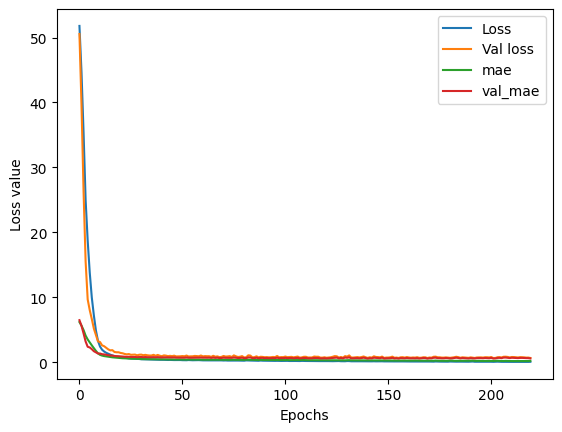

In [127]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

2/2 [==============================] - 0s 6ms/step
0.9408831138487735


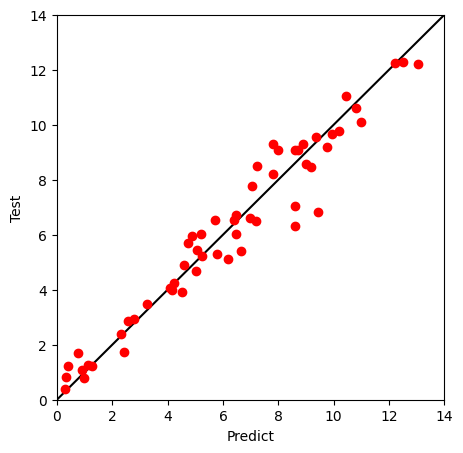

In [143]:
y_pred = model.predict(X_test_pca)
print(r2_score(y_test, y_pred))
plt.figure(figsize=(5,5))
plt.xlim((0,14))
plt.ylim((0,14))
plt.plot((0,14), (0, 14), c='k')
plt.plot(y_pred, y_test, "ro")
plt.xlabel('Predict')
plt.ylabel('Test')
plt.show()